<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

# 1. 使用MNIST 數據集進行圖像分類

在這個章節中，我們將實現深度學習的「Hello World」：訓練一個深度學習模型，以正確分類手寫數字。

## 1.1 目標

* 了解深度學習如何解決傳統程式設計方法無法解決的問題
* 了解 MNIST 手寫數字數據集 ([MNIST handwritten digits dataset](http://yann.lecun.com/exdb/mnist/))
* 使用  [torchvision](https://pytorch.org/vision/stable/index.html) 載入 MNIST 數據集並為訓練做準備
* 創建一個簡單的神經網路來進行圖像分類
* 使用準備好的 MNIST 數據集訓練神經網路
* 觀察訓練後神經網路的表現


讓我們開始載入這個 Notebook 中使用的函式庫：

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Visualization tools
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt


在 PyTorch 中，我們可以通過設定 [device](https://pytorch.org/docs/stable/tensor_attributes.html#torch.device) 為 `cuda` 來在運算中使用 GPU。函式 `torch.cuda.is_available()` 會確認 PyTorch 是否能夠識別到 GPU。



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

### 1.1.1 問題：圖像分類

在傳統程式設計中，程式設計師可以在程式碼中闡明規則和條件，以便程式正確地執行。這種方法在解決許多問題時仍然非常有效。

然而，圖像分類——要求程式正確地將它從未見過的圖像分類到正確的類別——幾乎無法使用傳統程式設計技術來解決。程式設計師如何定義出正確分類龐大數量圖像的規則和條件，尤其是那些從未見過的圖像呢？



### 1.1.2 解決方案：深度學習 (Deep Learning)


深度學習在模式識別方面通過試錯法表現出色。通過用足夠的數據訓練深度神經網路，並在訓練過程中提供網路的表現反饋，網路可以在大量迭代中自行確定一套正確的條件，以便正確地執行動作。

## 1.2 MNIST 資料集


在深度學習的歷史中，對 [MNIST 資料集](http://yann.lecun.com/exdb/mnist/) 進行準確的圖像分類是一項重要的發展。MNIST 資料集是一個包含 70,000 個手寫數字（從 0 到 9）的灰階圖像集合。雖然現在這個問題被認為是微不足道的，但使用 MNIST 進行圖像分類已經成為深度學習中的「Hello World」。



以下是 MNIST 資料集中包含的 40 個圖像：


<img src="./images/mnist1.png" style="width: 600px;">

### 1.2.1 訓練和驗證(Validation)資料與標籤(Labels) 

當我們使用圖像進行深度學習時，我們需要圖像本身（通常用 `X` 表示）和正確的 標籤（ [labels](https://developers.google.com/machine-learning/glossary#label), 通常用 `Y` 表示）。此外，我們需要 `X` 和 `Y` 值來*訓練*模型，並且需要另一組 `X` 和 `Y` 值來*驗證(validating)*模型在訓練後的表現。

我們可以把這些 X 和 Y 對視為一組記憶卡(flash cards)。學生可以使用一組記憶卡(flash cards)進行訓練，而老師可能會使用另一組記憶卡(flash cards)來測試學生是否學習了正確的概念。

因此，我們需要為 MNIST 資料集準備四個部分的資料：

1. `x_train`: 用於訓練神經網路的圖像
2. `y_train`: `x_train` 圖像的正確標籤，用于在訓練過程中評估模型的預測
3. `x_valid`:  設定為驗證模型在訓練後表現的圖像
4. `y_valid`: `x_valid` 圖像的正確標籤，用于在訓練後評估模型的預測


準備資料進行分析的過程被稱為 資料工程（[Data Engineering](https://medium.com/@rchang/a-beginners-guide-to-data-engineering-part-i-4227c5c457d7)）。若要了解訓練資料和驗證資料（以及測試資料）之間的差異，可以參考 Jason Brownlee 的 [這篇文章](https://machinelearningmastery.com/difference-test-validation-datasets/)。



### 1.2.2 使用 TorchVision 載入資料到記憶體中

目前有許多[深度學習框架](https://developer.nvidia.com/deep-learning-frameworks)，每個都有其優點。在這個工作坊中，我們將使用 [PyTorch 2](https://pytorch.org/get-started/pytorch-2.0/)，並且特別使用 [Sequential API](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)。Sequential API 具有許多用於構建神經網路的內建函式，並且由於其 可讀性 和效率，在專業環境中也是合理的選擇，雖然它並不是唯一的選擇。在開始深度學習專案時，你可以去嘗試多種框架。

我們還會使用 [TorchVision](https://pytorch.org/vision/stable/index.html) 函式庫。它提供了許多有用的功能，包括包含許多[常見資料集](https://pytorch.org/vision/main/datasets.html)的功能模組，包括 MNIST。

我們將開始載入  [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST)的 `train` 和 `valid` 資料集。



In [3]:
train_set = torchvision.datasets.MNIST("./data/", train=True, download=True)
valid_set = torchvision.datasets.MNIST("./data/", train=False, download=True)

如前所述，MNIST 資料集包含 70,000 個手寫數字的灰階圖像。通過執行以下程式碼，我們可以看到 TorchVision 將其中 60,000 個[PIL圖像](https://pillow.readthedocs.io/en/stable/reference/Image.html)用於訓練，10,000 個用於驗證（在訓練後）。



In [4]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train

In [5]:
valid_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test


*注意*: `valid_set` 的分割(`Split`)被標記為 `Test`，但在我們的實作練習中，我們將使用這些資料進行驗證。若要了解 `Train`、`Valid` 和 `Test` 資料集之間的差異，可以參考 Kili 的 [這篇文章](https://kili-technology.com/training-data/training-validation-and-test-sets-how-to-split-machine-learning-data)。



### 1.2.3 探索 MNIST 資料


讓我們從 `train_set` 中取出第一組 x、y ，並檢視資料結構：


In [6]:
x_0, y_0 = train_set[0]

In [7]:
x_0

In [8]:
type(x_0)

PIL.Image.Image


這是 5 還是一個寫得不好的 3？我們可以查看相應的標籤來確認。

In [9]:
y_0

5

In [10]:
type(y_0)

int

## 1.3 張量（Tensors）

如果向量是一維陣列，矩陣是二維陣列，那麼張量就是代表任意維度的n維陣列。絕大多數現代神經網路框架都是一個強大的張量處理工具。

例如一個三維張量可以是電腦螢幕上的像素。不同的維度分別是寬度、高度和色彩通道（channel）。電子遊戲使用矩陣數學來計算像素值，類似於神經網路計算張量的方式。這就是為什麼GPU是有效的張量處理機器的原因。

讓我們將圖像轉換成張量，以便稍後用神經網路進行處理。TorchVision有一個有用的函式可以將[PIL Images](https://pillow.readthedocs.io/en/stable/reference/Image.html) 轉換成張量，使用的是[ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)類別：



In [11]:
trans = transforms.Compose([transforms.ToTensor()])
x_0_tensor = trans(x_0)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


[PyTorch 張量](https://pytorch.org/docs/stable/tensors.html#torch.Tensor) 具有許多有用的屬性和方法。我們可以驗證資料類型：


In [12]:
x_0_tensor.dtype

torch.float32

我們可以驗證最小和最大值。PIL圖像的整數範圍是255，但[ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)類別將其轉換為浮點數範圍[0.0, 1.0]。


In [13]:
x_0_tensor.min()

tensor(0.)

In [14]:
x_0_tensor.max()

tensor(1.)

我們也可以查看每個維度的大小。PyTorch使用`C x H x W`的慣例，這意味著第一維度是色彩通道（channel），第二維度是高度，第三維度是寬度。

由於這些圖像是黑白的，所以只有1個色彩通道。圖像是正方形，高和寬均為28像素：


In [15]:
x_0_tensor.size()

torch.Size([1, 28, 28])

我們也可以直接查看值：


In [16]:
x_0_tensor

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

默認情況下，張量是由[CPU](https://www.arm.com/glossary/cpu)處理的。


In [17]:
x_0_tensor.device

device(type='cpu')

要將其移到GPU上，我們可以使用`.cuda`方法。


In [18]:
x_0_gpu = x_0_tensor.cuda()
x_0_gpu.device

device(type='cuda', index=0)

`.cuda`方法如果PyTorch未能識別GPU將會失敗。為了使代碼更具彈性，我們可以將張量傳送到(`to`)在這個notebook開始時識別的設備(`device`)上。這樣，當GPU可用時，程式碼將運行得更快，但如果沒有可用的GPU，程式碼也不會無法運行。


In [19]:
x_0_tensor.to(device).device

device(type='cuda', index=0)


有時，解釋這麼多數字可能很困難。幸好，TorchVision可以使用[to_pil_image](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.to_pil_image.html)函式將`C x H x W`張量轉回PIL圖像。

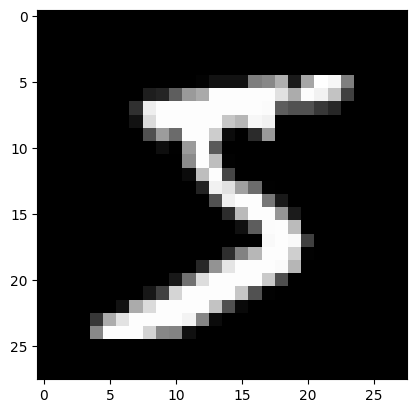

In [20]:
image = F.to_pil_image(x_0_tensor)
plt.imshow(image, cmap='gray')

## 1.4 準備訓練資料

之前，我們創建了一個`trans`變數來將圖像轉換成張量(tensor)。[Transforms](https://pytorch.org/vision/stable/transforms.html)是一組TorchVision函式，可以用來轉換資料集。

### 1.4.1 轉換(Transforms)功能


[Compose](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Compose.html#torchvision.transforms.v2.Compose)函式整合了一系列轉換功能(transforms)。我們稍後會在另一篇notebook中學習更多關於轉換功能(transforms)的內容，但目前已經先在下面將其定義到`trans`變數作為簡介。


In [21]:
trans = transforms.Compose([transforms.ToTensor()])


之前，我們只將`trans`應用於一個值。有多種方法可以將多個轉換功能應用於資料集。其中一種方法是將其設置為資料集的`transform`變數。


In [22]:
train_set.transform = trans
valid_set.transform = trans

### 1.4.2 DataLoaders

如果我們的資料集是一副閃存卡(flash cards)，[DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) 定義了如何從這副卡片中抽取卡片來訓練AI模型。我們可以一次將整個資料集展示給模型。不僅這需要大量的計算資源，[研究表明](https://arxiv.org/pdf/1804.07612)，使用較小的批次資料對於模型訓練更有效。

例如，如果我們的批次大小`batch_size`是32，我們將通過洗牌並抽取32張卡片來訓練模型。在驗證時不需要洗牌，因為模型不會學習，但我們仍會使用`batch_size`來防止記憶體錯誤。

批次大小由模型開發者決定，最佳值取決於要解決的問題。研究表明，32或64對於許多機器學習問題是足夠的，並且在一些機器學習框架中是預設值，因此我們這裡使用32。

In [23]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

## 1.5 建立模型

是時候建立模型了！神經網路由多層組成，每層對接收到的資料執行數學運算後，再傳遞給下一層。首先，我們將建立一個「Hello World」級別的模型，該模型由四個組件組成：

1. [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) ：用於將多維資料轉換為向量。
2. 輸入層(input layer)：第一層神經元
3. 隱藏層(hidden layer)：隱藏(hidden)於輸入層和輸出層之間的另一層神經元
4. 輸出層(output layer)：最後一組神經元，返回模型的最終預測

有關這些層的更多資訊，可以參考 Sarita 的[這篇部落格文章](https://medium.com/@sarita_68521/basic-understanding-of-neural-network-structure-eecc8f149a23)。

讓我們建立一個 `layers` 變數來儲存我們層的列表。

In [24]:
layers = []
layers

[]

### 1.5.1 圖像扁平化(Flattening)

當我們查看資料的形狀時，我們看到圖像有三個維度：`C x H x W`。要扁平化(flatten)圖像，意味著將所有這些維度合併成一維。假設我們有一個如下所示的張量。嘗試運行程式碼區塊以查看它在扁平化前後的外觀。


In [25]:
test_matrix = torch.tensor(
    [[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9]]
)
test_matrix

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [26]:
nn.Flatten()(test_matrix)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

什麼都沒有發生？那是因為神經網路預期接收一批資料。目前，Flatten 層看到的是三個向量，而不是一個 2D 矩陣。為了修正這個問題，我們可以通過添加一對額外的括號來「批量化」資料。由於 `test_matrix` 現在是一個張量，我們可以使用以下的簡寫來完成這個操作。`None` 添加一個新維度，而 `:` 選擇張量中的所有資料。


In [27]:
batch_test_matrix = test_matrix[None, :]
batch_test_matrix

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [28]:
nn.Flatten()(batch_test_matrix)

tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

順序很重要！以下是當我們以相反的順序進行操作時會發生的事情：


In [29]:
nn.Flatten()(test_matrix[:, None])

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

既然我們已經掌握了 `Flatten` 層的使用方法，現在讓我們將它添加到我們的層(`layers`)列表中。


In [30]:
layers = [
    nn.Flatten()
]
layers

[Flatten(start_dim=1, end_dim=-1)]

### 1.5.2 輸入層(Input Layer)

我們的第一層神經元將扁平化的圖像連接到模型的其餘部分。為此，我們將使用一個 [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) 層。這個層將是「*密集連接(densely connected)*」的，意味著其中的每個神經元及其權重都會影響下一層的每個神經元。

為了創建這些權重，PyTorch 需要知道輸入的大小以及我們想要創建的神經元數量。由於我們已經扁平化了圖像，因此輸入的大小是通道數、垂直像素數和水平像素數的乘積。


In [31]:
input_size = 1 * 28 * 28

選擇正確的神經元數量是「數據科學」中的「科學」部分，因為這涉及捕捉數據集的統計複雜性。目前，我們將使用 `512` 個神經元。稍後嘗試修改這個值，以觀察它如何影響訓練，並開始發展對這個數字的感覺。

我們稍後會學習更多關於活化函式(Activation Function)的內容，但目前，我們將使用 [relu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) 活化函式(Activation Function)，它簡而言之，將幫助我們的網路學習如何對資料做出更複雜的猜測，而不是基於某個嚴格的線性函式。



In [32]:
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU()]

### 1.5.3 隱藏層(Hidden Layer)

現在，我們將添加另一個密集連接的線性層。為什麼添加另一組神經元可以改善學習效果將在下一課中進行介紹。就像輸入層需要知道傳遞給它的資料形狀一樣，隱藏層的 [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) 也需要知道傳遞給它的資料形狀。前一層中的每個神經元都會計算出一個數字，因此傳入隱藏層的輸入數量與前一層中的神經元數量相同。



In [33]:
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU()  # Activation for hidden
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU()]

### 1.5.4 輸出層 (Output Layer)

最後，我們將添加一個輸出層 (Output Layer)。在這種情況下，由於網路需要對單個圖像進行猜測，並且圖像屬於 10 個可能類別之一，因此輸出將有 10 個神經元。每個輸出都分配給一個神經元。輸出神經元的值越大，模型就越預測輸入圖像屬於該神經元分配的類別。

我們不會在輸出層上使用 `ReLU` 函式。相反，我們將應用損失函式(`loss function`)於輸出層。我們會在下一節中介紹損失函式(`loss function`)。


In [34]:
n_classes = 10

layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
    nn.Linear(512, n_classes)  # Output
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=10, bias=True)]

### 1.5.5 編譯模型(Compiling the Model)

 一個[Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) 模型會預期一個序列(sequence)作為引數，而不是列表(list)，因此我們可以使用 [* 運算符(operator)](https://docs.python.org/3/reference/expressions.html#expression-lists)  將層列表(list of layers)解開成為序列(sequence)。我們可以印出(print)模型以驗證這些層是否正確載入。



In [35]:
model = nn.Sequential(*layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

與張量類似，當模型首次初始化時，它將在 CPU 上處理。要使其在 GPU 上處理，我們可以使用 `to(device)`。

In [36]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

要檢查模型所在的設備(device)，可以檢查模型參數(model parameters)所在的設備。更多資訊可以參考這個 [Stack Overflow 文章](https://stackoverflow.com/questions/58926054/how-to-get-the-device-type-of-a-pytorch-module-conveniently)。



In [37]:
next(model.parameters()).device

device(type='cuda', index=0)

[PyTorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) 引入了編譯模型的能力以獲得更快性能。更多資訊請參考 [這裡](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html)。

In [38]:
model = torch.compile(model)

## 1.6 訓練模型

既然我們已經準備好了訓練和驗證(validation)資料，以及一個模型，那麼現在是時候用我們的訓練資料來訓練模型，並用驗證資料來驗證它。

「用資料訓練模型」通常也被稱為「將模型適應(fitting)資料」。換句話說，這強調了模型的形狀(shape)會隨著時間，在更準確地理解它所接收到的資料後改變。



### 1.6.1 損失與優化(Loss and Optimization)

就像老師給學生評分一樣，我們需要為模型提供一個函式來評估其答案。這被稱為 損失函式(loss function)。我們將使用一種名為 [CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) 的損失函式，它旨在評估模型是否從許多不同種類中正確預測了正確的種類。


In [39]:
loss_function = nn.CrossEntropyLoss()

接下來，我們為模型選擇一個 優化器(`optimizer`)。如果 損失函式(`loss_function`) 提供了一個評分(grade)，優化器會告訴模型如何從這個評分中學習，以便下次做得更好。

In [40]:
optimizer = Adam(model.parameters())

### 1.6.2 計算準確度(Calculating Accuracy)

雖然損失函式的結果在幫助模型學習方面很有效，但其值對於人類來說可能很難解讀。這就是為什麼資料科學家經常包括其他指標，如準確度(accuracy)的原因。

為了準確計算準確度，我們應該比較正確分類的數量(number of correct classifications)與總預測數量(total number of predictions made)。由於我們以批次顯示資料給模型，因此我們可以與這些批次一起計算準確度。

首先，總預測數量與我們的資料集大小相同。讓我們將資料集的大小賦予 `N`，其中 `n` 等同於 批次大小(`batch size`)。


In [41]:
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)

接下來，我們將建立一個函式來計算每個批次的準確度。結果是總準確度的一個分數，因此我們可以將每個批次的準確度加起來以得到總準確度。


In [42]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

### 1.6.3 訓練函式(Train Function)

這裡是所有東西的集合地。下面是根據訓練資料定義的用於訓練模型的函式。我們稍後會更詳細地逐行解釋這段程式碼，但請花點時間來看看它的結構。你能夠認出我們之前創建的變數嗎？


In [43]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### 1.6.4 驗證函式(Validate Function)


類似地，這是用未曾用來訓練模型的資料進行驗證模型的程式碼。你能夠在這個 驗證函式(validate function) 和 訓練函式(`train` function) 之間找到一些差異嗎？

In [44]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### 1.6.5 訓練迴圈(Training Loop)

為了觀察模型的進展，我們將在訓練和驗證之間交替進行。就像學生可能需要多次瀏覽他們的閃卡才能學習所有概念一樣，模型將多次瀏覽訓練資料以獲得更好的理解。

一個 `epoch` 是對整個資料集的一次完整處理。讓我們訓練和驗證模型 5 個 `epoch` 來看看它如何學習。


In [45]:
epochs = 5

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 375.8499 Accuracy: 0.9380
Valid - Loss: 38.9991 Accuracy: 0.9588
Epoch: 1
Train - Loss: 157.7680 Accuracy: 0.9739
Valid - Loss: 32.8137 Accuracy: 0.9679
Epoch: 2
Train - Loss: 112.0163 Accuracy: 0.9816
Valid - Loss: 27.8152 Accuracy: 0.9736
Epoch: 3
Train - Loss: 84.6300 Accuracy: 0.9852
Valid - Loss: 21.3891 Accuracy: 0.9793
Epoch: 4
Train - Loss: 65.7143 Accuracy: 0.9887
Valid - Loss: 34.5820 Accuracy: 0.9702


我們已經接近 100% 了！讓我們通過在原始樣本上測試它來看看是否真的接近 100%。我們可以像使用函式一樣使用我們的模型：


In [46]:
prediction = model(x_0_gpu)
prediction

tensor([[-23.2196,  -6.1072, -16.9438,  14.0705, -26.9294,  12.2305, -20.6137,
         -17.8539,  -9.0149,  -6.7443]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)

應該有十個數字，每個數字對應不同的輸出神經元。由於這樣的資料結構，各個數字的索引與相應的手寫數字會相匹配。第 0 個索引是對應到手寫 0 的預測，第 1 個索引是對應到手寫 1 的預測，依此類推。

我們可以使用 `argmax` 函式來找到最高值的索引。


In [47]:
prediction.argmax(dim=1, keepdim=True)

tensor([[3]], device='cuda:0')

它是否正確地做出了預測？


In [48]:
y_0

5

## 1.7 總結

模型表現得非常好！準確度迅速接近 100%，驗證準確度也是如此。現在，我們有一個可以用來準確檢測和分類手寫圖像的模型。

下一步將是使用這個模型來分類尚未見過的手寫圖像。這被稱為 推理( [inference](https://blogs.nvidia.com/blog/2016/08/22/difference-deep-learning-training-inference-ai/))。我們將在稍後的練習中探索推理的過程。


值得花點時間來欣賞我們在這裡所做的事情。從歷史上看，為了完成這類任務而構建的專家系統非常複雜，人們花費了他們的職業生涯來建造它們（請參考 [官方 MNIST 頁面](http://yann.lecun.com/exdb/mnist/) 上的參考資料和里程碑時間）。

MNIST 不僅對電腦視覺具有歷史影響，而且它也是很好的 基準測試([benchmark](http://www.cs.toronto.edu/~serailhydra/publications/tbd-iiswc18.pdf)) 和除錯工具。遇到困難，無法讓一個新型的機器學習架構正常運作？試試看它是否能在這個資料集中學習。如果它無法在這個資料集中學習，那麼它很可能也無法在更複雜的圖像和資料集中學習。


### 1.7.1 清空記憶體

在繼續之前，請執行以下程式碼區塊以清空空 GPU 記憶體。這是繼續到下一個 Notebook 所需的。


In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### 1.7.2 下一步

在這個部分，你學到了如何為圖像分類建立和訓練一個簡單的神經網路。在下一個部分，你將被要求建立自己的神經網路並進行資料準備，以解決不同的圖像分類問題。

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>